In [2]:
import sys
import os
os.environ["CUDA VISIBLE DEVICES"]="4"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
np.set_printoptions(threshold=sys.maxsize)
from scipy import stats
from sklearn.model_selection import train_test_split
import math
import plotly.graph_objs as go
from scipy.optimize import minimize

## Ditributions using the MC truth photon directions

### Read PPC output file. 

In [32]:
my_file=pd.read_csv("Hits_hadronic_hrand_vrand_5GeV_30000events_4pi", sep=' ',header=None,usecols=range(0, 15))

dom_pos=pd.read_csv("geo-f2k_hrand_vrand",sep='\t',header=None)

z_adjust=1948.07
om_pos_x={}
om_pos_y={}
om_pos_z={}

for i in range(len(dom_pos)):
    om_pos_x["0"+str(dom_pos.loc[i][5])+"0"+str(dom_pos.loc[i][6])]=dom_pos.loc[i][2]
    om_pos_y["0"+str(dom_pos.loc[i][5])+"0"+str(dom_pos.loc[i][6])]=dom_pos.loc[i][3]
    om_pos_z["0"+str(dom_pos.loc[i][5])+"0"+str(dom_pos.loc[i][6])]=dom_pos.loc[i][4]+z_adjust
    
strings=my_file.iloc[range(0,len(my_file)),1].tolist()
doms=my_file.iloc[range(0,len(my_file)),2].tolist()

index=["0"+str(x)+"0"+str(y) for x,y in zip(strings,doms)]

hit_pos_x=[om_pos_x[x] for x in index]
hit_pos_y=[om_pos_y[y] for y in index]
hit_pos_z=[om_pos_z[z] for z in index]

v=0.3/1.31 #in m/ns

emm_loc_x=my_file.iloc[range(0,len(my_file)),12].tolist()
emm_loc_y=my_file.iloc[range(0,len(my_file)),13].tolist()
emm_loc_z=my_file.iloc[range(0,len(my_file)),14].tolist()

emm_x=my_file.iloc[range(0,len(my_file)),9].tolist()
emm_y=my_file.iloc[range(0,len(my_file)),10].tolist()
emm_z=my_file.iloc[range(0,len(my_file)),11].tolist()

scatt_time=[]
prop_time=[]
v=0.3/1.31 #in m/ns

prop_time = np.where(my_file.iloc[:,0] == 'TR', 0.0, my_file.iloc[:,3])
prop_time=[float(x) for x in prop_time]
        
scatt_time=[np.abs(p-np.sqrt((om_pos_x[indx]-loc_emm_x)**2+(om_pos_y[indx]-loc_emm_y)**2+(om_pos_z[indx]-loc_emm_z)**2)/v) for p,indx,loc_emm_x,loc_emm_y,loc_emm_z in zip(prop_time,index,emm_loc_x,emm_loc_y,emm_loc_z)]

frac_scatt_time = []
for x, y in zip(scatt_time, prop_time):
    if y == 0:
        frac_scatt_time.append(float('inf'))
    else:
        frac_scatt_time.append(x / y)
        
true_theta=my_file.iloc[range(0,len(my_file)),7].tolist()
true_phi=my_file.iloc[range(0,len(my_file)),8].tolist()
true_x=[-np.sin(np.radians(theta))*np.cos(np.radians(phi)) for theta,phi in zip(true_theta,true_phi)]
true_y=[-np.sin(np.radians(theta))*np.sin(np.radians(phi)) for theta,phi in zip(true_theta,true_phi)]
true_z=[-np.cos(np.radians(theta)) for theta in true_theta]

imp_theta=my_file.iloc[range(0,len(my_file)),5].tolist()
imp_phi=my_file.iloc[range(0,len(my_file)),6].tolist()

imp_z=[np.cos(x) for x in imp_theta]
imp_x=[np.sin(x)*np.cos(y) for x,y in zip(imp_theta,imp_phi)]
imp_y=[np.sin(x)*np.sin(y) for x,y in zip(imp_theta,imp_phi)]

d_theta=my_file.iloc[range(0,len(my_file)),7].tolist()
d_phi=my_file.iloc[range(0,len(my_file)),8].tolist()

In [33]:
hit_x=[]
hit_y=[]
hit_z=[]
dom_pos=[]
vert_pos=[]
t_obs=[]
cutoff=0.15
n_ph = 1.319
c = 0.3
n_gr = 1.356
angles_truth=[]  #opening angle between secondary charged particle and detected photon
delta_t_truth=[]  #difference between observed and geometric timestamp
delta_t_log_truth=[]  #log(difference between observed and geometric timestamp)
angles=[]

for i in range(len(my_file)):
    if my_file.iloc[i, 0] == 'TR':
        if len(hit_x) > 2:
            u = np.array([np.sin(theta_truth) * np.cos(phi_truth), np.sin(theta_truth) * np.sin(phi_truth), np.cos(theta_truth)])
            r=np.array(dom_pos)
            q=np.array(vert_pos)
            cross_prod = np.cross(u, r-q)
            d_gamma = n_ph * np.sqrt((1/(n_ph**2 - 1)) * np.sum(cross_prod**2, axis=1))
            t_geo = (1/c)*(np.abs(np.dot((r-q),u)) + (d_gamma/n_ph) * (n_ph*n_gr - 1))
                        
            t_obs=np.array(t_obs)
            t_geo=np.array(t_geo)
            
            delta_t_truth.extend(np.abs(t_obs-t_geo))
            delta_t_log_truth.extend(np.log(np.abs(t_obs-t_geo)))
            angles_truth.extend(angles)
                                            
        t_obs=[]
        dom_pos=[]
        vert_pos=[]
        dir_true_x = true_x[i]
        dir_true_y = true_y[i]
        dir_true_z = true_z[i]
        hit_x=[]
        hit_y=[]
        hit_z=[]
        theta_truth = np.arccos(true_z[i]) % np.pi
        phi_truth = math.atan2(true_y[i], true_x[i]) % (2*np.pi)       
        truth=np.array([dir_true_x,dir_true_y,dir_true_z])
        angles=[]
        
    elif (my_file.iloc[i, 0] == 'HIT'and frac_scatt_time[i]<=cutoff):
        t_obs.append(prop_time[i])
        dom_pos.append([om_pos_x[index[i]],om_pos_y[index[i]],om_pos_z[index[i]]])
        vert_pos.append([emm_loc_x[i],emm_loc_y[i],emm_loc_z[i]])
        hit_x.append(imp_x[i])
        hit_y.append(imp_y[i])
        hit_z.append(imp_z[i])
        hit = np.array([hit_x[-1], hit_y[-1], hit_z[-1]])
        angles.append(np.arccos(np.dot(truth,hit)))  

## Optimisation of fitting parameters

### a) Optimisation of gaussian kernel width 'n'

In [51]:
def get_optimised_bandwidth_angles(angles_truth,win_size):
    print("Optimising bandwidth now...")
    
    plt.figure(figsize=(15, 6))

    # Create three subplots, one for the KDE curve, one for the CDFs, and one for KS values
    ax1 = plt.subplot(131)
    ax2 = plt.subplot(132)
    ax3 = plt.subplot(133)

    # Plot the histogram
    hist, bins, patches = ax1.hist(angles_truth, bins=180, density=True, label='Histogram', histtype='step', lw=3)

    # Define the values of 'n' to try
    n_values = [0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42]

    # Calculate the histogram of the data
    bin_centers_angles_truth = (bins[:-1] + bins[1:]) / 2

    # Calculate the CDF of the histogram
    hist_cdf = np.cumsum(hist * np.diff(bins))
    #hist_cdf /= np.max(hist_cdf)

    # Plot the CDF of the histogram
    ax2.plot(bin_centers_angles_truth, hist_cdf, color='blue', label='Histogram', lw=2)

    # Initialize variables to store best fit results
    best_fit_n = None
    min_ks_statistic = np.inf
    ks_values = []

    # Loop over different values of 'n'
    for n in n_values:
         # Calculate the local densities using a window size
        window_size = win_size

        local_densities = np.zeros_like(bin_centers_angles_truth)
        for i, center in enumerate(bin_centers_angles_truth):
            num_neighbors = np.sum(np.abs(angles_truth - center) < window_size)
            local_densities[i] = num_neighbors

        # Calculate the variable bandwidths based on the local densities
        bandwidths = 1 / np.power(local_densities, n)

        # Evaluate the variable bandwidth KDE at each bin center
        kde_curve_angles_truth = np.zeros_like(bin_centers_angles_truth)
        for i, center in enumerate(bin_centers_angles_truth):
            weights = norm.pdf((center - angles_truth) / bandwidths[i])
            kde_curve_angles_truth[i] = np.sum(weights)

         # Normalize the KDE curve
        kde_curve_angles_truth /= np.trapz(kde_curve_angles_truth, bin_centers_angles_truth)

         # Plot the normalized KDE curve
        ax1.plot(bin_centers_angles_truth, kde_curve_angles_truth, linewidth=2, label='KDE, n=' + str(n))

        # Calculate the CDF of the KDE curve
        kde_cdf = np.cumsum(kde_curve_angles_truth * np.diff(bins))
       # kde_cdf /= np.max(kde_cdf)

        # Plot the CDF of the KDE curve
        ax2.plot(bin_centers_angles_truth, kde_cdf, label='KDE, n=' + str(n), lw=2)

        # Calculate the KS statistic
        ks_statistic = np.max(np.abs(kde_cdf-hist_cdf))
        ks_values.append(ks_statistic)
        print(f"For n={n}: KS statistic = {ks_statistic}")

        # Update the best fit 'n' value if the KS statistic is lower
        if ks_statistic < min_ks_statistic:
            min_ks_statistic = ks_statistic
            best_fit_n = n

    # Plot the KS values versus n
    ax3.plot(n_values, ks_values, marker='o', linestyle='-', color='purple')
    ax3.set_xlabel('n', fontsize=12)
    ax3.set_ylabel('KS statistic', fontsize=12)
    ax3.set_title(f'KS Values, window size = {window_size}'+'rad', fontsize=15)

    # Set the labels and titles for the first two subplots
    ax1.set_xlabel('Angle [rad]', fontsize=12)
    ax1.set_ylabel('Density', fontsize=12)
    ax1.set_title(f'KDE Curve, window size = {window_size}'+'rad',fontsize=15)
    ax2.set_xlabel('Angle [rad]', fontsize=12)
    ax2.set_ylabel('Cumulative Probability', fontsize=12)
    ax2.set_title(f'CDF Comparison, window size = {window_size}'+'rad',fontsize=15)

    # Add legends to the first two subplots
    ax1.legend(fontsize=10)
    ax2.legend(fontsize=10)

    # Print the best fit 'n' value and the corresponding KS statistic
    print(f"Best Fit n: {best_fit_n}")
    print(f"KS statistic: {min_ks_statistic}")

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()

    return best_fit_n

### b) Optimisation of window size 

In [50]:
def get_optimised_window_angles(angles_truth, n_opt):
    print("Optimising window size now...")
    
    plt.figure(figsize=(20, 6))
    # Create three subplots, one for the KDE curve, one for the CDFs, and one for KS values
    ax1 = plt.subplot(131)
    ax2 = plt.subplot(132)
    ax3 = plt.subplot(133)

    # Plot the histogram
    hist, bins, patches = ax1.hist(angles_truth, bins=30, density=True, label='Histogram', histtype='step', lw=3)

    # Define the range of window sizes to try
    window_sizes = np.arange(0.3, np.pi, 0.3)

    # Calculate the histogram of the data
    bin_centers_angles_truth = (bins[:-1] + bins[1:]) / 2

    # Calculate the CDF of the histogram
    hist_cdf = np.cumsum(hist * np.diff(bins))

    # Plot the CDF of the histogram
    ax2.plot(bin_centers_angles_truth, hist_cdf, color='blue', label='Histogram', lw=2)

    # Initialize variables to store best fit results
    best_fit_window_size = None
    min_ks_statistic = np.inf
    ks_values = []

    n=n_opt  #Optimised value of n

    # Loop over different window sizes
    for window_size in window_sizes:
        # Calculate the local densities using the window size
        local_densities = np.zeros_like(bin_centers_angles_truth)
        for i, center in enumerate(bin_centers_angles_truth):
            num_neighbors = np.sum(np.abs(angles_truth - center) < window_size)
            local_densities[i] = num_neighbors

        # Calculate the variable bandwidths based on the local densities
        bandwidths = 1 / np.power(local_densities, n)

        # Evaluate the variable bandwidth KDE at each bin center
        kde_curve_angles_truth = np.zeros_like(bin_centers_angles_truth)
        for i, center in enumerate(bin_centers_angles_truth):
            weights = norm.pdf((center - angles_truth) / bandwidths[i])
            kde_curve_angles_truth[i] = np.sum(weights)

        # Normalize the KDE curve
        kde_curve_angles_truth /= np.trapz(kde_curve_angles_truth, bin_centers_angles_truth)

        # Plot the normalized KDE curve
        ax1.plot(bin_centers_angles_truth, kde_curve_angles_truth, linewidth=2, label='KDE, window size=' + str(window_size))

        # Calculate the CDF of the KDE curve
        kde_cdf = np.cumsum(kde_curve_angles_truth * np.diff(bins))

        # Plot the CDF of the KDE curve
        ax2.plot(bin_centers_angles_truth, kde_cdf, label='KDE, window size=' + str(window_size), lw=2)

        # Calculate the KS statistic
        ks_statistic = np.max(np.abs(kde_cdf - hist_cdf))
        ks_values.append(ks_statistic)
        print(f"For window size={window_size}: KS statistic = {ks_statistic}")

        # Update the best fit window size if the KS statistic is lower
        if ks_statistic < min_ks_statistic:
            min_ks_statistic = ks_statistic
            best_fit_window_size = window_size

    # Plot the KS values versus window size
    ax3.plot(window_sizes, ks_values, marker='o', linestyle='-', color='purple')
    ax3.set_xlabel('Window Size', fontsize=12)
    ax3.set_ylabel('KS statistic', fontsize=12)
    ax3.set_title('KS Values', fontsize=15)

    # Set the labels and titles for the first two subplots
    ax1.set_xlabel('Angle [rad]', fontsize=12)
    ax1.set_ylabel('Density', fontsize=12)
    ax1.set_title('KDE Curve', fontsize=15)
    ax2.set_xlabel('Angle [rad]', fontsize=12)
    ax2.set_ylabel('Cumulative Probability', fontsize=12)
    ax2.set_title('CDF Comparison', fontsize=15)

    # Add legends to the first two subplots
    ax1.legend(fontsize=10)
    ax2.legend(fontsize=10)

    # Print the best fit window size and the corresponding KS statistic
    print(f"Best Fit Window Size: {best_fit_window_size}")
    print(f"KS statistic: {min_ks_statistic}")

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()

    return best_fit_window_size

## Final KDE Fit

Optimising bandwidth now...
For n=0.3: KS statistic = 0.0008857812581279378
For n=0.31: KS statistic = 0.000788640397196616
For n=0.32: KS statistic = 0.0006921572264356191
For n=0.33: KS statistic = 0.0005970051311562363
For n=0.34: KS statistic = 0.0005043458917190491
For n=0.35: KS statistic = 0.0004156535048817078
For n=0.36: KS statistic = 0.000332388287362928
For n=0.37: KS statistic = 0.0002556554493802765
For n=0.38: KS statistic = 0.00019938001628472257
For n=0.39: KS statistic = 0.00020880350391649927
For n=0.4: KS statistic = 0.00022606521092438658
For n=0.41: KS statistic = 0.00029646799429550175
For n=0.42: KS statistic = 0.0003943758279469911
Best Fit n: 0.38
KS statistic: 0.00019938001628472257


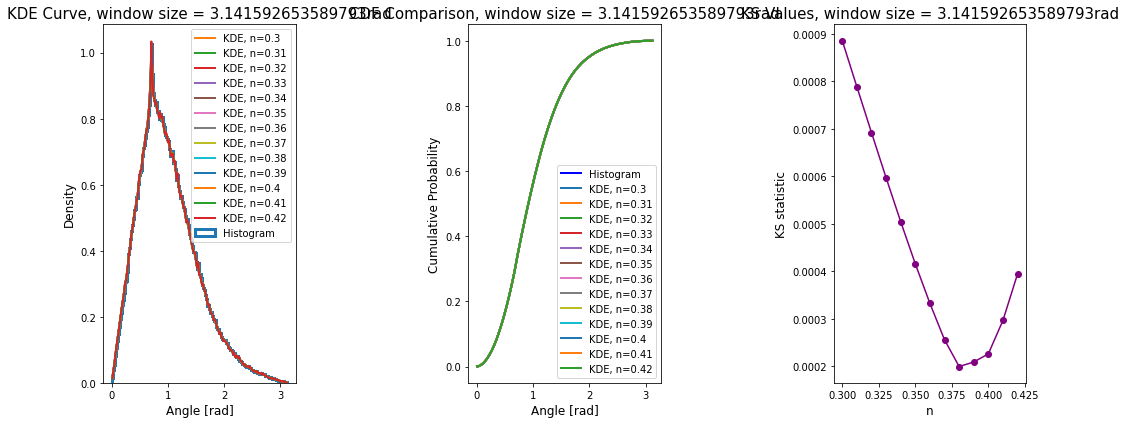

Optimising window size now...
For window size=0.3: KS statistic = 0.08073704653470859
For window size=0.6: KS statistic = 0.06353460170188874
For window size=0.8999999999999999: KS statistic = 0.041209112456015995
For window size=1.2: KS statistic = 0.02117943068029715
For window size=1.5: KS statistic = 0.008554037270593784
For window size=1.8: KS statistic = 0.0039587656870267995
For window size=2.0999999999999996: KS statistic = 0.00387920496727312
For window size=2.4: KS statistic = 0.0042010086947655845
For window size=2.6999999999999997: KS statistic = 0.004377766747244771
For window size=2.9999999999999996: KS statistic = 0.004393753365890873
Best Fit Window Size: 2.0999999999999996
KS statistic: 0.00387920496727312


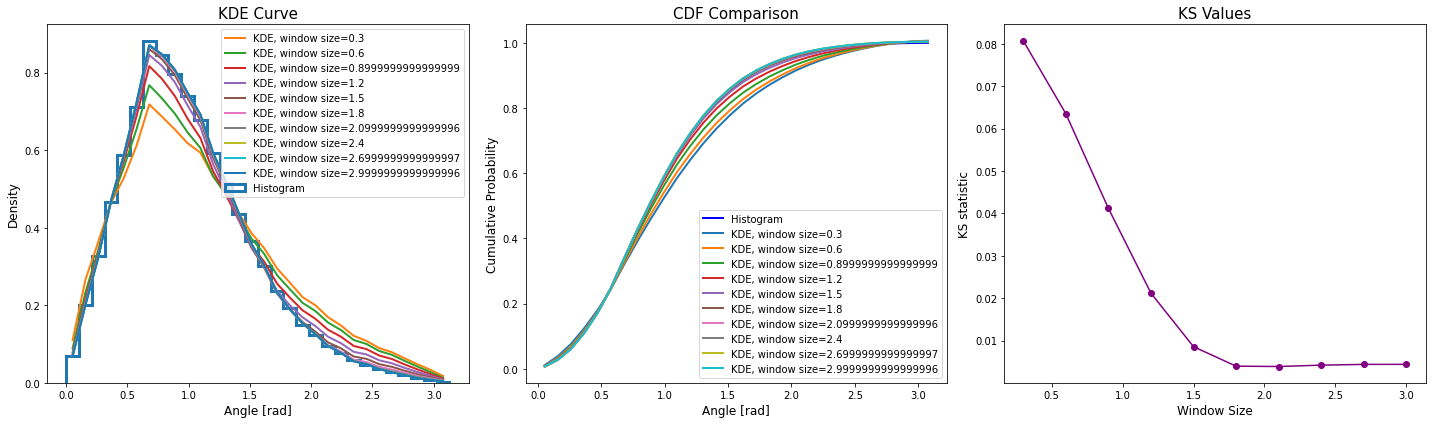

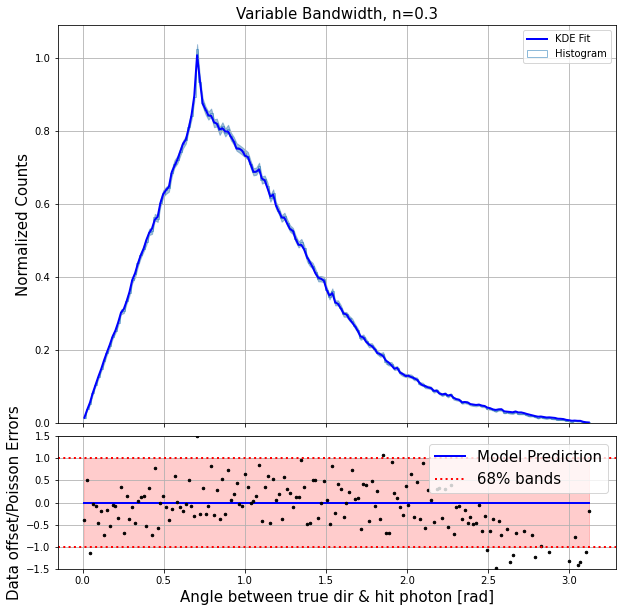

In [54]:
#Call optimisation functions
window_size=np.pi
n_opt=get_optimised_bandwidth_angles(angles_truth,window_size)
window_opt=get_optimised_window_angles(angles_truth,n_opt)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Calculate histogram
hist, bins, patches = ax1.hist(angles_truth, density=True, bins=180, alpha=0.5, label='Histogram', histtype='step')

# Calculate the bin centers
bin_centers_angles_truth= (bins[:-1] + bins[1:]) / 2

bin_pop = (hist / np.sum(hist)) * len(angles_truth)
binwidth=bins[2]-bins[1]

error_heights=np.sqrt(bin_pop)/(np.sum(bin_pop)*binwidth)

#error_heights = hist/np.sqrt(np.sum(hist**2))

# Define the range of values for the KDE evaluation
x = np.linspace(min(angles_truth), max(angles_truth), 180)

local_densities = np.zeros_like(bin_centers_angles_truth)
for i, center in enumerate(bin_centers_angles_truth):
    num_neighbors = np.sum(np.abs(angles_truth - center) < window_opt)
    local_densities[i] = num_neighbors

# Calculate the variable bandwidths based on the local densities
bandwidths = 1 / np.power(local_densities, n_opt)

# Evaluate the variable bandwidth KDE at each bin center
kde_curve_angles_truth = np.zeros_like(bin_centers_angles_truth)
for i, center in enumerate(bin_centers_angles_truth):
    weights = norm.pdf((center - angles_truth) / bandwidths[i])
    kde_curve_angles_truth[i] = np.sum(weights)

# Normalize the KDE curve
kde_curve_angles_truth /= np.trapz(kde_curve_angles_truth, bin_centers_angles_truth)

# Plot the individual KDEs and the combined KDE
ax1.plot(bin_centers_angles_truth, kde_curve_angles_truth, linewidth=2, label='KDE Fit',color='blue')
#ax1.set_xlabel('Data')
ax1.set_ylabel('Density',fontsize=15)
ax1.legend(loc='upper right',fontsize=15)
ax1.grid(True)
ax1.set_title("Variable Bandwidth, n=" + str(n), fontsize=15)

# Plot the model prediction line on the second subplot for every 2nd bin
ax2.plot(bin_centers_angles_truth, np.zeros_like(bin_centers_angles_truth), 'r-', linewidth=2, label='Model Prediction', color='blue')

# Calculate the data offset from the model prediction for every 2nd bin
offset = (hist- kde_curve_angles_truth) / error_heights

# Plot the data offset without error bars on the second subplot
ax2.plot(bin_centers_angles_truth, offset, '.', markersize=5, color='black')

# Plot shaded region between y=-1 and y=1
ax2.fill_between(bin_centers_angles_truth, -1, 1, color='red', alpha=0.2)

# Plot dotted lines at -1 and +1
ax2.axhline(y=-1, color='red', linestyle='dotted', lw=2,label='68% bands')
ax2.axhline(y=1, color='red', linestyle='dotted', lw=2)

peak_index = np.argmax(hist)
peak_value = bins[peak_index]

# Format and display the legend on the first subplot
ax1.legend()

ax1.fill_between(bin_centers_angles_truth , hist - error_heights, hist + error_heights, color='steelblue', alpha=0.5, label='Errors')

# Set the limits of the second subplot
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel('Angle between true dir & hit photon [rad]',fontsize=15)
ax2.set_ylabel('Data offset/Poisson Errors',fontsize=15)
ax2.grid(True)
ax2.legend(loc='upper right',fontsize=15)
ax2.set_ylim(-1.5,1.5)
#plt.xlim(0.6,1)

ax1.set_ylabel('Normalized Counts',fontsize=15)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.05)
#plt.legend(fontsize=15)

plt.show()


## Do this for timing PDF as well. Finally, the combined 2D KDE follows. 

### Optimisation of bandwidth parameter for 2D KDE

In [ ]:
def get_optimised_bandwidth_combined(angles_truth, delta_t_log_truth, window_size_x, window_size_y):
    print("Optimising bandwidth parameter now...")
    # Define the values of 'n' to try
    n_values = [0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.40]

    sample_size = 50000

    # Randomly sample from the data
   # sample_size = min(len(angles_truth), len(delta_t_log_truth))
    sample_indices = np.random.choice(np.arange(sample_size), size=sample_size, replace=False)
    sample_angles = angles_truth[sample_indices]
    sample_delta_t = delta_t_log_truth[sample_indices]

    # Calculate the histogram of the data
    histogram, x_edges, y_edges = np.histogram2d(sample_angles, sample_delta_t, bins=[50,50], density=True)

    # Calculate the bin widths
    x_bin_width = np.diff(x_edges)[0]
    y_bin_width = np.diff(y_edges)[0]

    # Calculate the CDF of the histogram
    hist_cdf = np.cumsum(histogram.flatten() * x_bin_width * y_bin_width)

    # Initialize variables to store best fit results
    best_fit_n = None
    min_ks_statistic = np.inf
    ks_values = []

    # Loop over different values of 'n'
    for n in n_values:
        # Calculate the local densities using the window sizes
        local_densities = np.zeros_like(histogram)
        for i in range(histogram.shape[0]):
            for j in range(histogram.shape[1]):
                num_neighbors = np.sum(
                    (np.abs(sample_angles - x_edges[i]) < window_size_x)
                    & (np.abs(sample_delta_t - y_edges[j]) < window_size_y)
                )
                local_densities[i, j] = num_neighbors

        # Calculate the variable bandwidths based on the local densities
        bandwidths = 1 / np.power(local_densities, n)

        # Evaluate the variable bandwidth KDE at each data point
        kde_values = np.zeros_like(histogram)
        for i in range(histogram.shape[0]):
            for j in range(histogram.shape[1]):
                weights = norm.pdf((sample_angles - x_edges[i]) / bandwidths[i, j]) * norm.pdf(
                    (sample_delta_t - y_edges[j]) / bandwidths[i, j]
                )
                kde_values[i, j] = np.sum(weights)

        bin_centers_del_t_truth = (y_edges[:-1] + y_edges[1:]) / 2
        bin_centers_angles_truth = (x_edges[:-1] + x_edges[1:]) / 2
        kde_values = kde_values / np.trapz(np.trapz(kde_values, x=bin_centers_del_t_truth, axis=1), x=bin_centers_angles_truth)

        # Calculate the CDF of the KDE values
        kde_cdf = np.cumsum(kde_values.flatten() * x_bin_width * y_bin_width)
      #  kde_cdf /= np.max(kde_cdf)

        # Calculate the KS statistic between the histogram and KDE values
        ks_statistic = np.max(np.abs(kde_cdf-hist_cdf))
        ks_values.append(ks_statistic)
        print(f"For n={n}: KS statistic = {ks_statistic}")

        # Update the best fit 'n' value if the KS statistic is lower
        if ks_statistic < min_ks_statistic:
            min_ks_statistic = ks_statistic
            best_fit_n = n

    print("Best fit n:", best_fit_n)
    # Plot the KS values versus n
    plt.plot(n_values, ks_values, marker="o", linestyle="-", color="purple")
    plt.xlabel("n", fontsize=12)
    plt.ylabel("KS statistic", fontsize=12)
    plt.title("KS Values", fontsize=15)
    plt.grid(True)

    # Show the plot
    plt.show()

    return best_fit_n

### Optimisation of window parameter for 2D KDE

In [78]:
def get_optimised_window_combined(angles_truth, delta_t_log_truth, n_opt):
    print("Optimising window sizes now...")
    num_samples=50000

    # Specify the range of values for window sizes
    window_size_x_values = np.arange(0.1, 2.5, 0.5)
    window_size_y_values = np.arange(0.1, 6.0, 0.5)

    # Initialize the array to store the KS statistics
    ks_values = np.zeros((len(window_size_x_values), len(window_size_y_values)))

    x_range = (0, 2.5)
    y_range = (-1, 5)

    # Filter the data within the specified range
    filtered_indices = np.where(
        (angles_truth >= x_range[0])
        & (angles_truth <= x_range[1])
        & (delta_t_log_truth >= y_range[0])
        & (delta_t_log_truth<= y_range[1])
    )

    filtered_angles = angles_truth[filtered_indices]
    filtered_delta_t = delta_t_log_truth[filtered_indices]

    #Sampling a small fraction of the angles and delta_t in the high statistics region
    sampled_angles = np.random.choice(filtered_angles, size=num_samples, replace=False)
    sampled_delta_t = np.random.choice(filtered_delta_t, size=num_samples, replace=False)

    # Calculate the hist of the sampled data
    histogram, x_edges, y_edges = np.histogram2d(sampled_angles, sampled_delta_t, bins=[50,50], density=True)

    # Calculate the bin widths
    x_bin_width = np.diff(x_edges)[0]
    y_bin_width = np.diff(y_edges)[0]
    hist_cdf = np.cumsum(histogram.flatten() * x_bin_width * y_bin_width)
    #hist_cdf /= np.max(hist_cdf)

    # Optimize the window size
    for i, window_size_x in enumerate(window_size_x_values):
        for j, window_size_y in enumerate(window_size_y_values):
            # Calculate the local densities using the window sizes
            local_densities = np.zeros_like(histogram)
            for k in range(histogram.shape[0]):
                for l in range(histogram.shape[1]):
                    num_neighbors = np.sum(
                        (np.abs(sampled_angles - x_edges[k]) < window_size_x)
                        & (np.abs(sampled_delta_t - y_edges[l]) < window_size_y)
                    )
                    local_densities[k, l] = num_neighbors

            # Calculate the variable bandwidths based on the local densities
            bandwidths = 1 / np.power(local_densities, best_fit_n)

            # Evaluate the variable bandwidth KDE at each data point
            kde_curve_2d_truth = np.zeros_like(histogram)
            for k in range(histogram.shape[0]):
                for l in range(histogram.shape[1]):
                    weights = norm.pdf((sampled_angles - x_edges[k]) / bandwidths[k, l]) * norm.pdf(
                         (sampled_delta_t - y_edges[l]) / bandwidths[k, j]
                    )
                    kde_curve_2d_truth[i, j] = np.sum(weights)

            bin_centers_delta_t_truth = (y_edges[:-1] + y_edges[1:]) / 2
            bin_centers_angles_truth = (x_edges[:-1] + x_edges[1:]) / 2
            kde_curve_2d_truth = kde_curve_2d_truth / np.trapz(np.trapz(kde_curve_2d_truth, x=bin_centers_delta_t_truth, axis=1), x=bin_centers_angles_truth)

            # Calculate the CDF of the KDE values
            kde_cdf = np.cumsum(kde_curve_2d_truth.flatten() * x_bin_width * y_bin_width)
          #  kde_cdf /= np.max(kde_cdf)
        
        # Calculate the KS statistic between the histogram and KDE values
            ks_statistic = np.max(np.abs(kde_cdf-hist_cdf))
            ks_values[i, j] = ks_statistic
            print(ks_statistic)

    return window_size_x_values[np.unravel_index(ks_values.argmin(), ks_values.shape)[0]], window_size_y_values[np.unravel_index(ks_values.argmin(), ks_values.shape)[1]]

Optimising bandwidth parameter now...
For n=0.25: KS statistic = 0.028901706948190886
For n=0.26: KS statistic = 0.028545449412809953
For n=0.27: KS statistic = 0.02817650023392998
For n=0.28: KS statistic = 0.027822638987589188
For n=0.29: KS statistic = 0.02750742991473143
For n=0.3: KS statistic = 0.027244759470349933
For n=0.31: KS statistic = 0.02703835898860535
For n=0.32: KS statistic = 0.026888512571822176
For n=0.33: KS statistic = 0.02680370353895245
For n=0.34: KS statistic = 0.02680968763307412
For n=0.35: KS statistic = 0.026947516137160565
Best fit n: 0.33


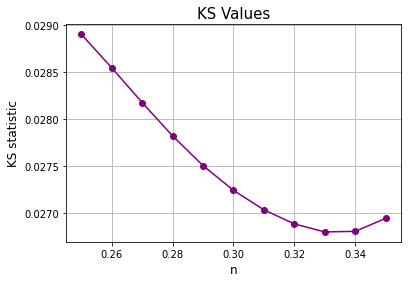

Optimising window sizes now...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning:

divide by zero encountered in true_divide



3.999999999999997
2.0000000000000004
2.0000000000000004
1.9999999999999998
2.000000000000001
2.0
2.0000000000000004
1.9999999999999998
2.0
1.9999800000000014
1.9999800000000014
1.9999399999999998
1.998259999999998
0.9982599999999999
0.99824
0.9982399999999999
0.9982200000000002
0.9982199999999999
0.9982199999999999
0.9982199999999999
0.9982199999999999
0.9981800000000004
0.9981800000000006
0.9981799999999996
1.993019999999998
0.9930199999999999
0.9930199999999999
0.9930199999999997
0.99302
0.9930199999999999
0.9930199999999999
0.9930199999999997
0.9929999999999997
0.9929800000000002
0.9929400000000005
0.9928599999999992
1.983939999999998
0.9839399999999999
0.9839399999999999
0.9839399999999997
0.98394
0.9839399999999999
0.9839399999999999
0.9839399999999999
0.9839199999999997
0.9838400000000005
0.9838000000000005
0.9837599999999996
1.972279999999998
0.9722799999999999
0.9722799999999999
0.9722799999999997
0.97226
0.9722399999999999
0.9721999999999998
0.9721999999999996
0.97217999999999

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: RuntimeWarning:

divide by zero encountered in true_divide



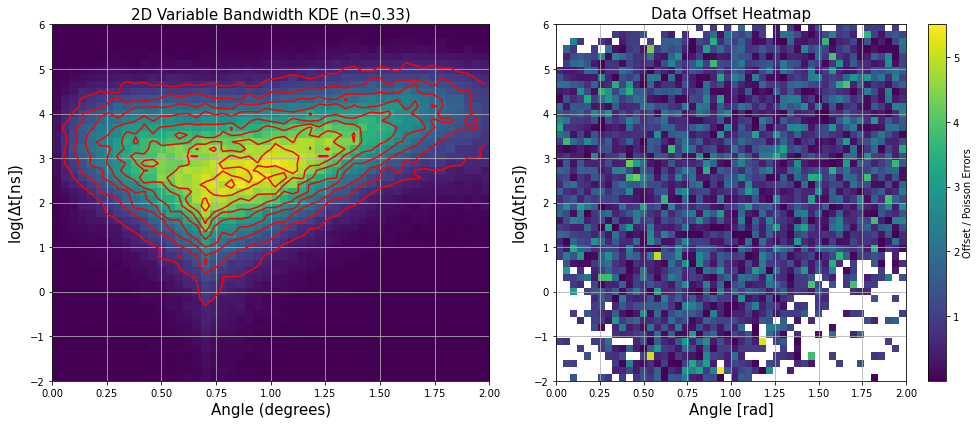

In [80]:
angles_truth=np.array(angles_truth)
delta_t_log_truth=np.array(delta_t_log_truth)

#Call optimisation functions
window_size_x = round(np.max(angles_truth) - np.min(angles_truth), 2)
window_size_y = round(np.max(delta_t_log_truth) - np.min(delta_t_log_truth), 2)
n_opt=get_optimised_bandwidth_combined(angles_truth,delta_t_log_truth, window_size_x, window_size_y)
window_x_opt, window_y_opt=get_optimised_window_combined(angles_truth, delta_t_log_truth, n_opt)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Define the range of values for the KDE evaluation
x_range = (0, 2.0)
y_range = (-2, 6)

# Filter the data within the specified range
filtered_indices = np.where(
    (angles_truth >= x_range[0])
    & (angles_truth <= x_range[1])
    & (delta_t_log_truth >= y_range[0])
    & (delta_t_log_truth <= y_range[1])
)

filtered_angles = angles_truth[filtered_indices]
filtered_delta_t = delta_t_log_truth[filtered_indices]

# Calculate the hist of the filtered data
hist, x_edges, y_edges = np.histogram2d(filtered_angles, filtered_delta_t, bins=[50, 50], density=True)

# Calculate the bin centers
x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_bin_centers = (y_edges[:-1] + y_edges[1:]) / 2

# Calculate the bin widths
x_bin_width = np.diff(x_edges)[0]
y_bin_width = np.diff(y_edges)[0]

# Calculate the bin populations and error heights
bin_pop = (hist / np.sum(hist)) * len(filtered_angles)
bin_area = x_bin_width * y_bin_width
error_heights = np.sqrt(bin_pop) / (np.sum(bin_pop) * bin_area)

# Define the window sizes for the x and y dimensions
window_size_x = window_x_opt
window_size_y = window_y_opt

# Calculate the local densities using the window sizes
local_densities = np.zeros_like(hist)
for i in range(hist.shape[0]):
    for j in range(hist.shape[1]):
        num_neighbors = np.sum(
            (np.abs(filtered_angles - x_edges[i]) < window_size_x)
            & (np.abs(filtered_delta_t - y_edges[j]) < window_size_y)
        )
        local_densities[i, j] = num_neighbors
        
n=n_opt

# Calculate the variable bandwidths based on the local densities
bandwidths = 1 / np.power(local_densities, n)

# Evaluate the variable bandwidth KDE at each data point
kde_values = np.zeros_like(hist)
for i in range(hist.shape[0]):
    for j in range(hist.shape[1]):
        weights = norm.pdf((filtered_angles - x_bin_centers[i]) / bandwidths[i, j]) * norm.pdf(
            (filtered_delta_t - y_bin_centers[j]) / bandwidths[i, j]
        )
        kde_values[i, j] = np.sum(weights)

kde_values = kde_values / np.trapz(np.trapz(kde_values, x=y_bin_centers, axis=1), x=x_bin_centers)

# Plot the hist as a 2D map
ax1.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], cmap='viridis', aspect='auto')
ax1.set_xlim(x_range[0], x_range[1])
ax1.set_ylim(y_range[0], y_range[1])

# Calculate the levels for contour lines
contour_levels = np.linspace(np.min(kde_values), np.max(kde_values), 10)

# Plot the KDE contours on top of the hist
ax1.contour(x_bin_centers, y_bin_centers, kde_values.T, levels=contour_levels, colors='red', linewidths=1.5)
ax1.set_xlabel('Angle (degrees)',fontsize=15)
ax1.set_ylabel('log($\Delta$t[ns])',fontsize=15)
ax1.set_title('2D Variable Bandwidth KDE (n='+str(n)+")",fontsize=15)

# Calculate the data offset
offset = np.abs(hist - kde_values) / error_heights

# Plot the data offset as a heatmap with colorbar
heatmap = ax2.imshow(offset.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], cmap='viridis', aspect='auto')
ax2.set_xlabel('Angle [rad]',fontsize=15)
ax2.set_ylabel('log($\Delta$t[ns])',fontsize=15)
ax2.set_title('Data Offset Heatmap',fontsize=15)
plt.colorbar(heatmap, ax=ax2, label='Offset / Poisson Errors')
ax1.set_ylim(y_range[0], y_range[1])
ax2.set_ylim(y_range[0], y_range[1])
ax1.set_xlim(x_range[0], x_range[1])
ax2.set_xlim(x_range[0], x_range[1])

ax1.grid(True)
ax2.grid(True)

# Adjust spacing between subplots
plt.tight_layout()

plt.show()
